In [1]:
import kagglehub
itachi9604_disease_symptom_description_dataset_path = kagglehub.dataset_download('itachi9604/disease-symptom-description-dataset')

print('Data source import complete.')


100%|██████████| 30.1k/30.1k [00:00<00:00, 10.4MB/s]

Extracting files...
Data source import complete.


In [ ]:
import joblib

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,KFold,cross_val_score,GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,classification_report,precision_score,roc_curve
import seaborn as sns
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

**Read and shuffle the dataset**

In [ ]:
df = pd.read_csv('/kaggle/input/disease-symptom-description-dataset/dataset.csv')
df = shuffle(df,random_state=42)
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
373,Acne,skin_rash,blackheads,scurring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4916,Acne,skin_rash,pus_filled_pimples,blackheads,scurring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1550,Hyperthyroidism,fatigue,mood_swings,weight_loss,restlessness,sweating,diarrhoea,fast_heart_rate,excessive_hunger,muscle_weakness,irritability,abnormal_menstruation,NaN,NaN,NaN,NaN,NaN,NaN
3081,AIDS,muscle_wasting,patches_in_throat,high_fever,extra_marital_contacts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3857,Chronic cholestasis,itching,vomiting,yellowish_skin,nausea,loss_of_appetite,abdominal_pain,yellowing_of_eyes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=df)

MessageError: Error: credential propagation was unsuccessful

**Removing Hyphen from strings**

In [ ]:
for col in df.columns:

    df[col] = df[col].str.replace('_',' ')
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
373,Acne,skin rash,blackheads,scurring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4916,Acne,skin rash,pus filled pimples,blackheads,scurring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1550,Hyperthyroidism,fatigue,mood swings,weight loss,restlessness,sweating,diarrhoea,fast heart rate,excessive hunger,muscle weakness,irritability,abnormal menstruation,NaN,NaN,NaN,NaN,NaN,NaN
3081,AIDS,muscle wasting,patches in throat,high fever,extra marital contacts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3857,Chronic cholestasis,itching,vomiting,yellowish skin,nausea,loss of appetite,abdominal pain,yellowing of eyes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Dataset characteristics**

In [ ]:
df.describe()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
count,4920,4920,4920,4920,4572,3714,2934,2268,1944,1692,1512,1194,744,504,306,240,192,72
unique,41,34,48,54,50,38,32,26,21,22,21,18,11,8,4,3,3,1
top,Acne,vomiting,vomiting,fatigue,high fever,headache,nausea,abdominal pain,abdominal pain,yellowing of eyes,yellowing of eyes,irritability,malaise,stomach bleeding,chest pain,chest pain,loss of smell,muscle pain
freq,120,822,870,726,378,348,390,264,276,228,198,120,126,72,96,144,72,72


**Check for null and NaN values**

In [ ]:
null_checker = df.apply(lambda x: sum(x.isnull())).to_frame(name='count')
print(null_checker)

            count
Disease         0
Symptom_1       0
Symptom_2       0
Symptom_3       0
Symptom_4     348
Symptom_5    1206
Symptom_6    1986
Symptom_7    2652
Symptom_8    2976
Symptom_9    3228
Symptom_10   3408
Symptom_11   3726
Symptom_12   4176
Symptom_13   4416
Symptom_14   4614
Symptom_15   4680
Symptom_16   4728
Symptom_17   4848


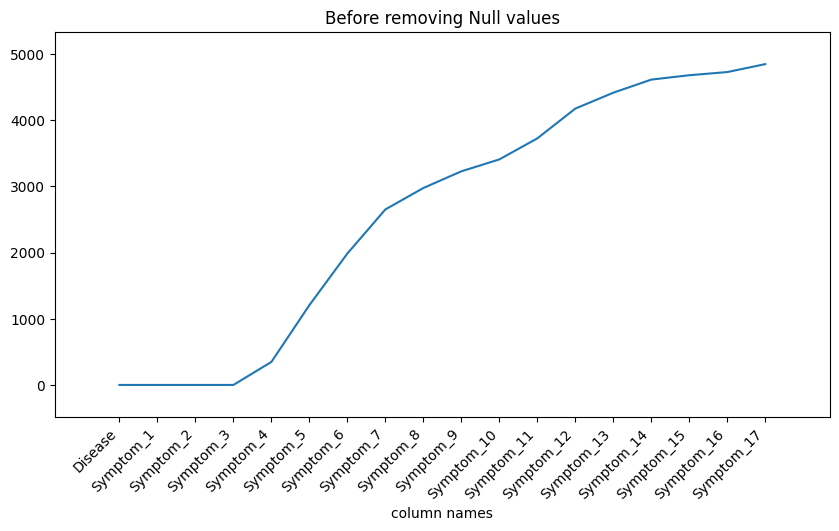

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(null_checker.index, null_checker['count'])
plt.xticks(null_checker.index, null_checker.index, rotation=45,
horizontalalignment='right')
plt.title('Before removing Null values')
plt.xlabel('column names')
plt.margins(0.1)
plt.show()

**Remove the trailing space from the symptom columns**

In [ ]:
cols = df.columns
data = df[cols].values.flatten()

s = pd.Series(data)
s = s.str.strip()
s = s.values.reshape(df.shape)

df = pd.DataFrame(s, columns=df.columns)
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Acne,skin rash,blackheads,scurring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Acne,skin rash,pus filled pimples,blackheads,scurring,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Hyperthyroidism,fatigue,mood swings,weight loss,restlessness,sweating,diarrhoea,fast heart rate,excessive hunger,muscle weakness,irritability,abnormal menstruation,NaN,NaN,NaN,NaN,NaN,NaN
3,AIDS,muscle wasting,patches in throat,high fever,extra marital contacts,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Chronic cholestasis,itching,vomiting,yellowish skin,nausea,loss of appetite,abdominal pain,yellowing of eyes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Fill the NaN values with zero**

In [ ]:
df = df.fillna("null")
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17,symptoms_list
373,Acne,skin_rash,blackheads,scurring,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"[ skin_rash, blackheads, scurring]"
4916,Acne,skin_rash,pus_filled_pimples,blackheads,scurring,null,null,null,null,null,null,null,null,null,null,null,null,null,"[ skin_rash, pus_filled_pimples, blackheads,..."
1550,Hyperthyroidism,fatigue,mood_swings,weight_loss,restlessness,sweating,diarrhoea,fast_heart_rate,excessive_hunger,muscle_weakness,irritability,abnormal_menstruation,null,null,null,null,null,null,"[ fatigue, mood_swings, weight_loss, restle..."
3081,AIDS,muscle_wasting,patches_in_throat,high_fever,extra_marital_contacts,null,null,null,null,null,null,null,null,null,null,null,null,null,"[ muscle_wasting, patches_in_throat, high_fe..."
3857,Chronic cholestasis,itching,vomiting,yellowish_skin,nausea,loss_of_appetite,abdominal_pain,yellowing_of_eyes,null,null,null,null,null,null,null,null,null,null,"[itching, vomiting, yellowish_skin, nausea,..."


Tranforming Data

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer

symptom_cols = [f"Symptom_{i}" for i in range(1, 18)]
df['symptoms_list'] = df[symptom_cols].apply(lambda x: [s for s in x if pd.notnull(s)], axis=1)

mlb = MultiLabelBinarizer()
X = mlb.fit_transform(df['symptoms_list'])


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

y = df['Disease']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("Accuracy:", model.score(X_test, y_test))


Accuracy: 1.0


In [ ]:
df2 = df[['Disease','symptoms_list']]
df2

,Disease,symptoms_list
373,Acne,"[ skin_rash, blackheads, scurring, null, nul..."
4916,Acne,"[ skin_rash, pus_filled_pimples, blackheads,..."
1550,Hyperthyroidism,"[ fatigue, mood_swings, weight_loss, restle..."
3081,AIDS,"[ muscle_wasting, patches_in_throat, high_fe..."
3857,Chronic cholestasis,"[itching, vomiting, yellowish_skin, nausea,..."
...,...,...
4426,Psoriasis,"[ skin_rash, joint_pain, skin_peeling, silv..."
466,Peptic ulcer diseae,"[ vomiting, indigestion, loss_of_appetite, ..."
3092,Dengue,"[ skin_rash, chills, joint_pain, vomiting, ..."
3772,Fungal infection,"[itching, skin_rash, nodal_skin_eruptions, ..."


### Disease Distribution Pie Chart

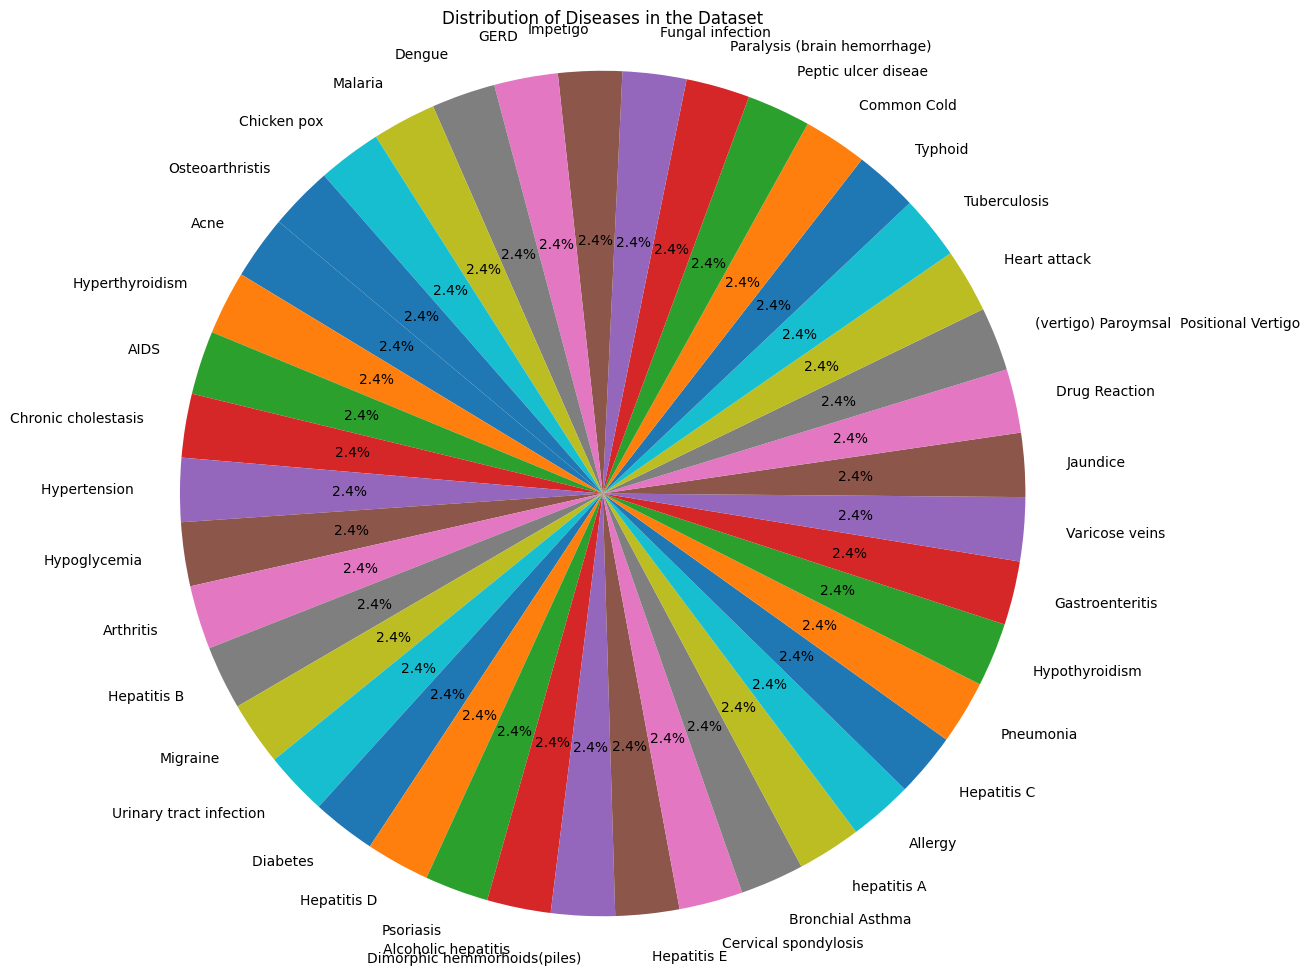

In [ ]:
disease_counts = df['Disease'].value_counts()

plt.figure(figsize=(12, 12))
plt.pie(disease_counts, labels=disease_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Diseases in the Dataset')
plt.axis('equal')
plt.show()

### Training and Testing Split Pie Chart

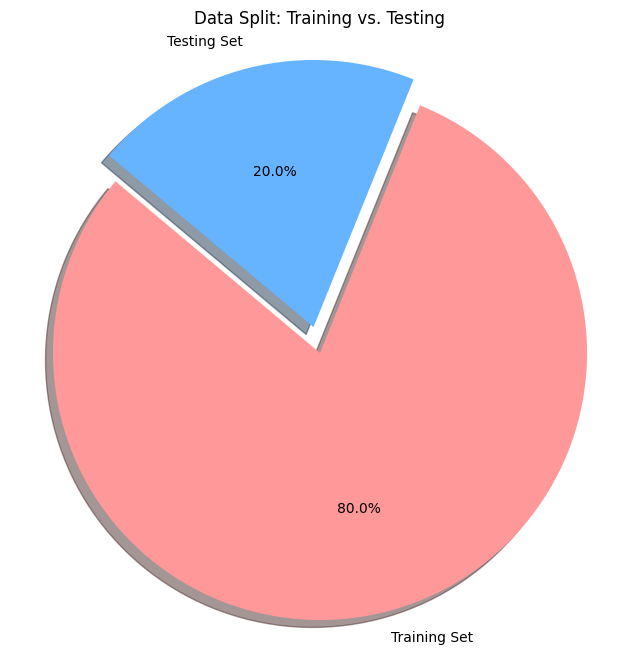

In [ ]:
labels = ['Training Set', 'Testing Set']
sizes = [80, 20]
colors = ['#ff9999','#66b3ff']
explode = (0.1, 0)
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Data Split: Training vs. Testing')
plt.show()

### How Random Forest Works (Conceptual Diagram)

Random Forest is an ensemble learning method that operates by constructing a multitude of decision trees during training and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

Here's a simplified conceptual diagram of how it works:

1.  **Multiple Decision Trees:**
    *   Imagine you have many individual experts (decision trees).
    *   Each expert is trained on a slightly different subset of your data and considers a random subset of features.

2.  **Independent Predictions:**
    *   When you want to make a prediction for a new input, you feed it to *every* one of these experts.
    *   Each expert makes its own prediction.

3.  **Voting/Averaging:**
    *   For classification tasks (like predicting a disease), all experts "vote" on the most likely outcome. The prediction with the most votes wins.
    *   For regression tasks, the predictions from all experts are averaged together.

**Conceptual Flow (for Classification):**

```
+-----------------------+   +-----------------------+   +-----------------------+
|    Decision Tree 1    |   |    Decision Tree 2    |   |         ...           |
|   (Expert 1, trained  |   |   (Expert 2, trained  |   |   (Expert N, trained  |
|  on Subset A, Features X)| |  on Subset B, Features Y)| |  on Subset C, Features Z)|
+-----------^-----------+   +-----------^-----------+   +-----------^-----------+
            |                           |                           |
            +---------------------------+---------------------------+
                                        |
                                New Data Point (e.g., Patient Symptoms)
                                        |
            +---------------------------+---------------------------+
            |                           |                           |
+-----------v-----------+   +-----------v-----------+   +-----------v-----------+
|  Prediction 1 (e.g.,  |   |  Prediction 2 (e.g.,  |   |  Prediction N (e.g.,  |
|     'Disease A')      |   |     'Disease B')      |   |     'Disease A')      |
+-----------------------+   +-----------------------+   +-----------------------+
            |                           |                           |
            +---------------------------+---------------------------+
                                        |
                                   Voting Mechanism
                                        |
                                +------------------+
                                |  Final Prediction  |
                                |  ('Disease A' -   |
                                |   Most Votes)     |
                                +------------------+
```

This diagram illustrates that each tree works independently on the input, and their individual predictions are combined (voted on) to reach a final, robust prediction.

### Confusion Matrix

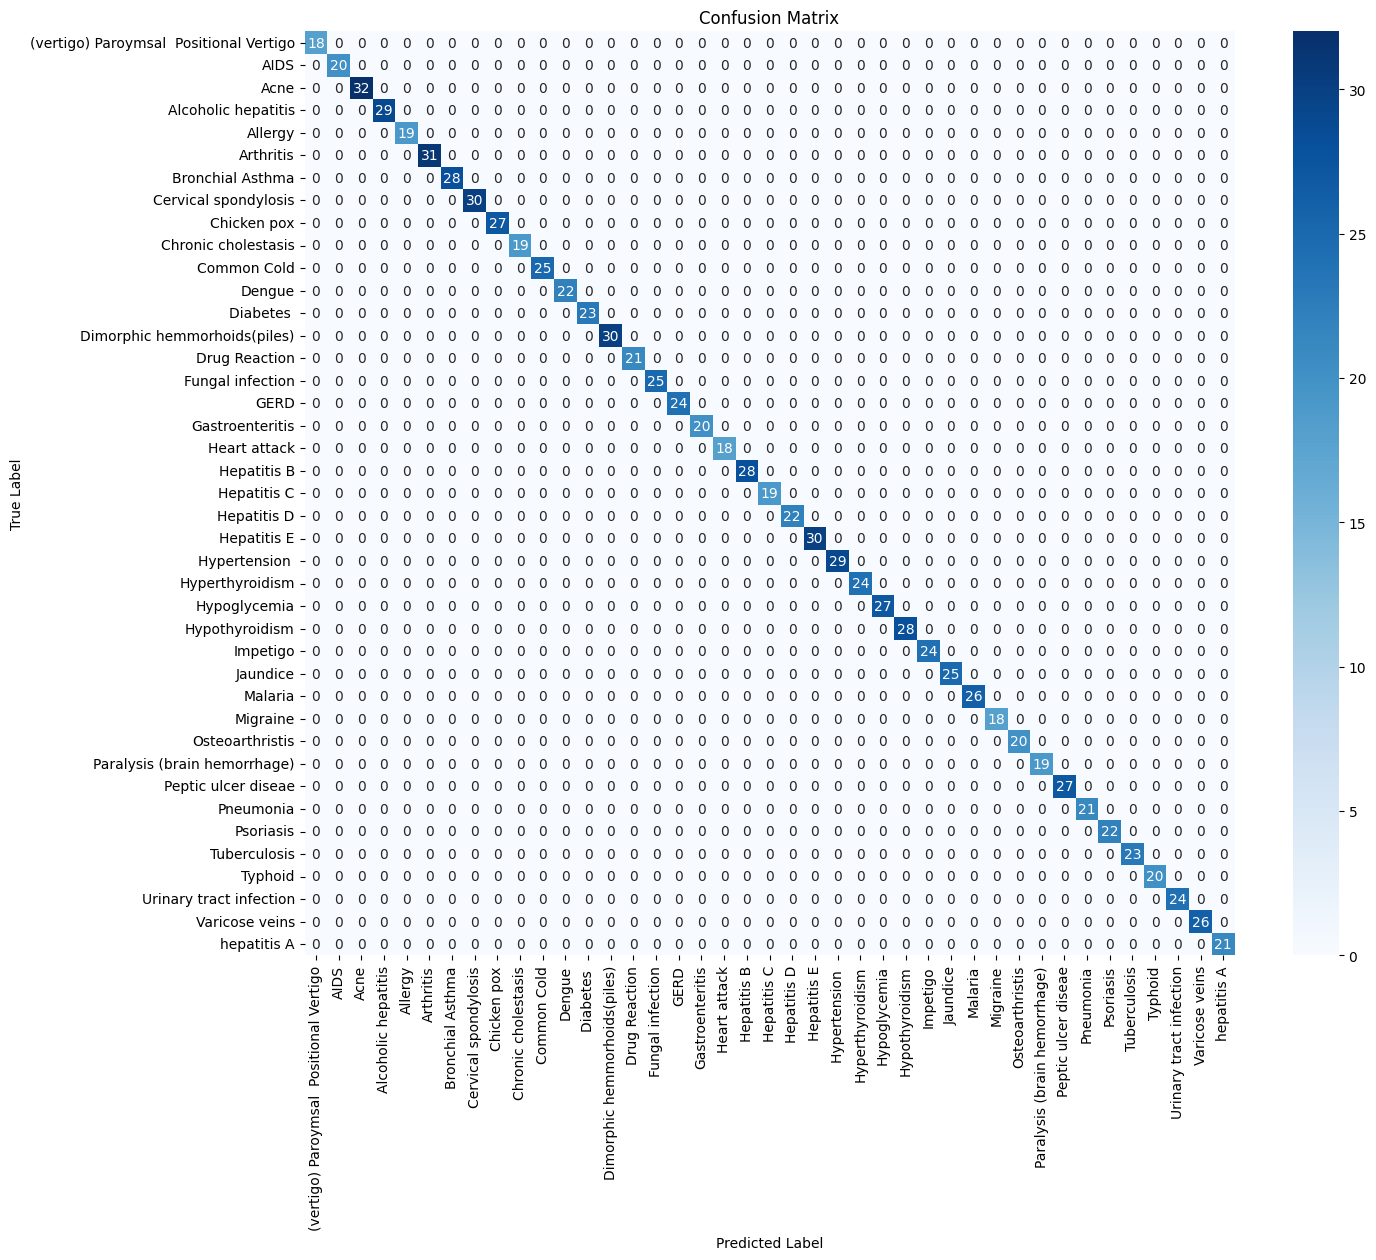

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### Model Performance Metrics Bar Chart

/tmp/ipython-input-376174881.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Metric', y='Score', data=metrics_df, palette='viridis')


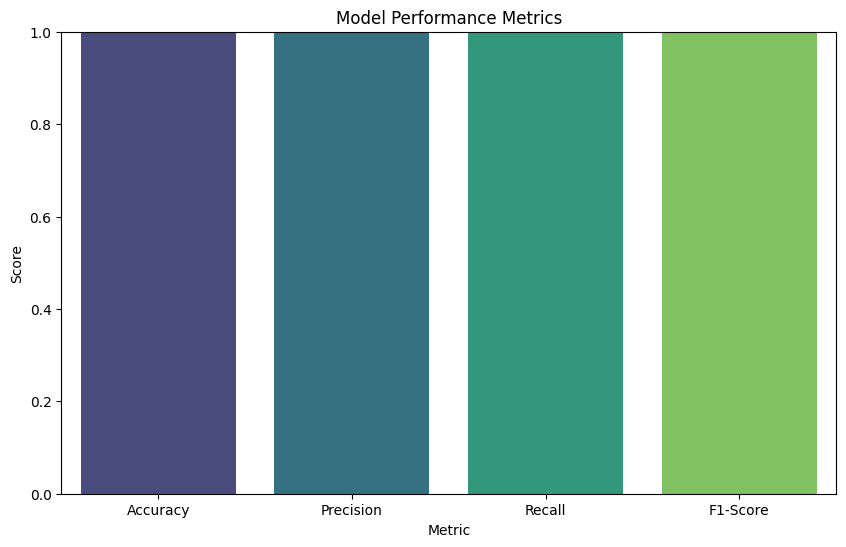


Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      1.00      1.00        18
                                   AIDS       1.00      1.00      1.00        20
                                   Acne       1.00      1.00      1.00        32
                    Alcoholic hepatitis       1.00      1.00      1.00        29
                                Allergy       1.00      1.00      1.00        19
                              Arthritis       1.00      1.00      1.00        31
                       Bronchial Asthma       1.00      1.00      1.00        28
                   Cervical spondylosis       1.00      1.00      1.00        30
                            Chicken pox       1.00      1.00      1.00        27
                    Chronic cholestasis       1.00      1.00      1.00        19
                            Common Cold       1.00      1.00      1.00        25
   

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

metrics_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [accuracy, precision, recall, f1]
}
metrics_df = pd.DataFrame(metrics_data)

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Score', data=metrics_df, palette='viridis')
plt.ylim(0.0, 1.0)
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

In [ ]:
input_symptoms = ["skin rash", "skin peeling",'joint pain']  # any n symptoms

input_vector = mlb.transform([input_symptoms])  # note the list inside list

input_vector
predicted_disease = model.predict(input_vector)
print("Predicted Disease:", predicted_disease[0])

Predicted Disease: Cervical spondylosis


/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_label.py:909: UserWarning: unknown class(es) ['joint pain', 'skin peeling', 'skin rash'] will be ignored
  warnings.warn(
